# Réseau d'accès radio TP
Lucas Hocquette - Quentin Goulas

# Exercice 1

In [87]:
import numpy as np
import matplotlib.pyplot as plt

In [88]:
# 1
def sample_users(K,R):
    v = np.random.uniform(low=0,high=R**2,size=K)
    theta = np.random.uniform(low=0,high=2*np.pi,size=K)
    r = np.sqrt(v)
    x,y = r*np.cos(theta), r*np.sin(theta)
    return x,y

In [89]:
# 2
r = 1
W = 3.84*10**6
theta = 0.4
sigma2 = 10**(-104/10)*1e-3
P = 10**(40/10)*1e-3

def measure_achievement_ratio(K,R,gamma,n_avg=1):
    x,y = sample_users(K,r)
    d = np.sqrt(x**2+y**2)
    L = -128.1 - 37.6*np.log10(d)
    l = 10**(L/10)
    history = np.zeros(n_avg)
    for i in range(n_avg):
        h = np.random.exponential(0.5,K)
        g = l*h
        p = P/K
        SINR = W/R*p*g/(theta*(K-1)*p*g+sigma2)
        history[i] = np.mean(SINR>=gamma)

    return history

print(f'The percentage of users for which the decoding condition is satisified is : {measure_achievement_ratio(20,32*1e3,10**(7/10))[0]*100}%')

The percentage for which the decoding condition is satisified is : 100.0%


In [90]:
# 3 and 4

achievement_ratio = measure_achievement_ratio(20,32*1e3,10**(7/10),100)
print(f'delta = {np.mean(achievement_ratio)*100}%')

delta = 98.4%


[1.         1.         1.         1.         1.         0.99333333
 0.99285714 0.9875     0.99444444 0.982      0.99272727 0.985
 0.98692308 0.99285714 0.98466667 0.98875    0.98176471 0.97666667
 0.98315789 0.9865     0.97809524 0.97090909 0.98521739 0.97708333
 0.9744     0.96730769 0.95148148 0.96178571 0.97103448 0.96466667
 0.94741935 0.9640625  0.95333333 0.95470588 0.93857143 0.94361111
 0.93243243 0.91578947 0.91974359 0.924      0.91243902 0.90666667
 0.89534884 0.91931818 0.87044444 0.88673913 0.88297872 0.859375
 0.85285714 0.8204     0.80019608 0.78961538 0.78433962 0.77962963
 0.67745455 0.6375     0.63403509 0.49206897 0.37457627 0.25683333
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.      

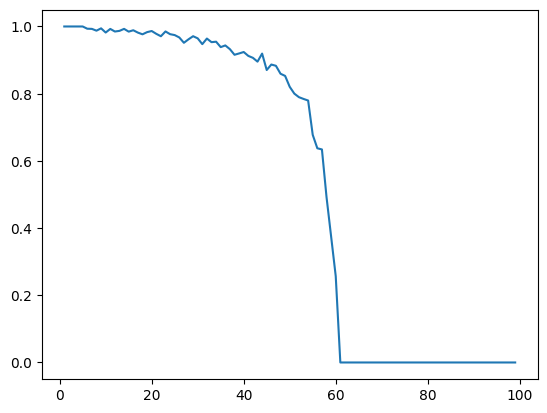

In [91]:
# 5

K_values = np.array(range(1,100))
deltas = np.zeros(len(K_values))

for i,K in enumerate(K_values) :
    ach_rat = measure_achievement_ratio(K,32*1e3,10**(7/10),100)
    deltas[i] = np.mean(ach_rat)

print(deltas)
print(f'The maximum number of users on the network is {K_values[np.sum(deltas>=0.9)]}')

plt.plot(K_values,deltas)
plt.show()

# Exercice 2

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
print(np.__version__)

1.22.4


$$ 
F = \begin{pmatrix} 
        0, \frac{g_2}{R_1g_1}, \cdots, \frac{g_k}{R_1g_1} \\
        \frac{g_1}{R_2g_2}, 0, \ddots, \vdots \\
        \vdots, \ddots, \ddots, \vdots \\
        \frac{g_1}{R_kg_k}, \cdots, \cdots, 0
    \end{pmatrix}       
$$

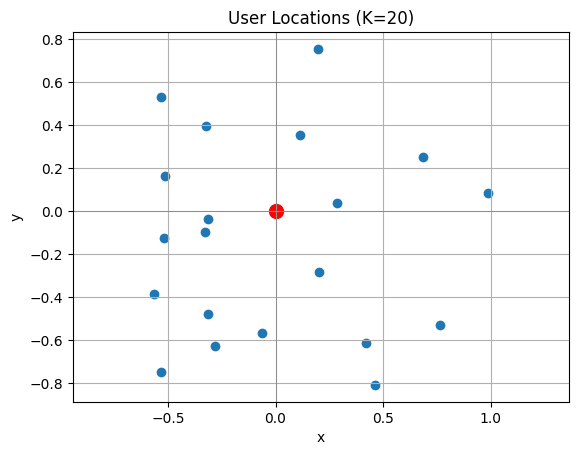

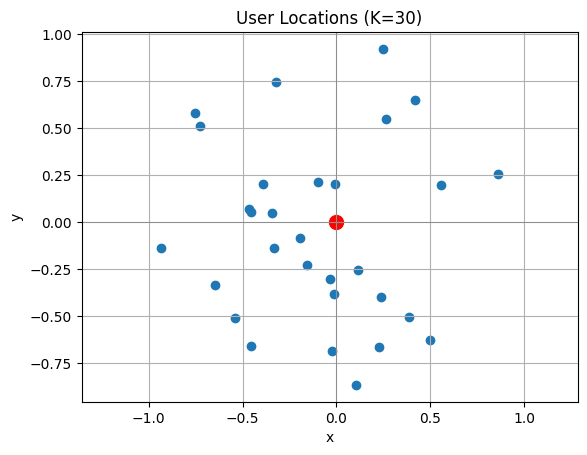

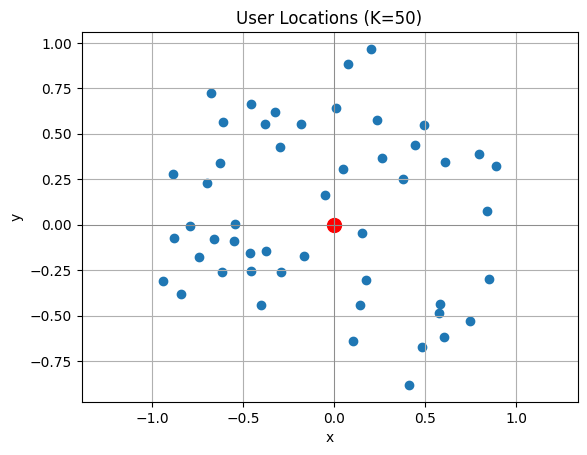

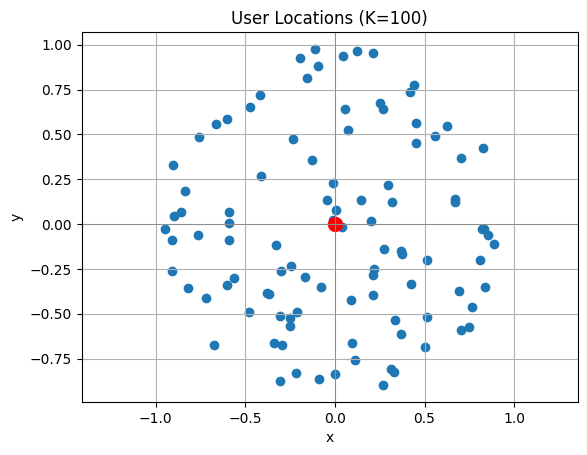

In [93]:
# 1.a

def sample_users(K,R):
    v = np.random.uniform(low=0,high=R**2,size=K)
    theta = np.random.uniform(low=0,high=2*np.pi,size=K)
    r = np.sqrt(v)
    x,y = r*np.cos(theta), r*np.sin(theta)
    return x,y

for K in [20,30,50,100]:
    # Example usage
    R = 1
    x, y = sample_users(K, R)

    plt.scatter(x, y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"User Locations (K={K})")
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.axis('equal')
    plt.gca().set_aspect('equal')
    plt.grid(True)
    plt.scatter(0, 0, color='red', s=100)
    plt.show()

In [94]:
# 1.b
# K = np.array([20, 30, 50, 100],dtype=np.int32)
K = np.array(range(10,100,2), dtype=np.int32)
R = 1
r1,r2 = 15*1e3,32*1e3
W = 3.84*10**6
theta = 0.4
gamma1, gamma2  = 10**(5/10), 10**(7/10)
Rho = np.array([])

def generate_F(k,R,r1,r2,gamma1,gamma2,W,theta):
    x,y = sample_users(k,R)
    r = np.concatenate((r1*np.ones(k//2),r2*np.ones(k//2)))
    gamma = np.concatenate((gamma1*np.ones(k//2),gamma2*np.ones(k//2)))
    lamda = 0.5
    # h = np.random.exponential(1/lamda,k)
    h = np.ones(k)
    d = np.sqrt(x**2+y**2)
    L = -128.1 - 37.6*np.log10(d)
    l = 10**(L/10)
    g = l*h
    G1,G2 = np.meshgrid(gamma*r*g,g)
    F = (theta/W)*G1 / G2
    F[np.eye(k,dtype=bool)] = 0
    return F, r, gamma, g

for k in K:
    F,_,_,_ = generate_F(k,R,r1,r2,gamma1,gamma2,W,theta)
    rho = np.max(np.abs(np.linalg.eigvals(F)))
    Rho = np.append(Rho,rho)

Kmax = np.max(K[Rho<1])
print(Kmax)

92


In [95]:

#1.c
k = Kmax

x,y = sample_users(k,R)
r = np.concatenate((r1*np.ones(k//2),r2*np.ones(k//2)))
gamma = np.concatenate((gamma1*np.ones(k//2),gamma2*np.ones(k//2)))
lamda = 0.5
h = np.ones(k)
d = np.sqrt(x**2+y**2)
L = -128.1 - 37.6*np.log10(d)
l = 10**(L/10)
g = l*h
G1,G2 = np.meshgrid(gamma*r*g,g)
F = (theta/W)*G1 / G2
F[np.eye(k,dtype=bool)] = 0

sigma2 = 10**(-104/10)/1000
b = sigma2*(1/(3.84*10**6))*r*gamma/g
P =  np.linalg.inv(np.eye(k) - F)@b

print(10*np.log10(P*1000)) # display the power allocation in dBm

def SINR(W,R,P,G,theta,sigma2):
    alpha = W/R
    pg = P*G
    p,_ = np.meshgrid(P,P)
    p[np.eye(len(p),dtype=bool)] = 0
    sm = np.sum(p,axis=1)*g
    return alpha*pg/(theta*sm+sigma2)

[-1.83698043 21.73215008 22.64494533 17.57080651 24.39055378 21.29565883
 25.6940927  25.20719593 26.76104521  4.25284456 24.68588565 20.51108102
 26.01997493 23.27641996 16.5036058  11.27109172 15.36692956 25.75837835
 21.54883477 22.28783891 26.71843209 24.90060074 14.67324006 15.53327274
 25.28760054  0.32660982 19.54869147 19.4273856  20.9954985   7.41407792
 13.86734139 25.53401224 19.65845892 17.09570679 26.59346972 25.14297818
 24.74836652 12.58968429 17.39780231  6.8423976  14.43327322 24.08765449
 22.23974224 26.23558919 22.14119293 20.18905403 18.60397834  9.90246134
 14.32232009 17.41418549  6.95615831 15.73735779 23.1428956  26.13307124
 25.86624893 23.18802638 26.83117792 24.68936802  6.60937617 25.31728408
 16.00117787 16.759361   17.63299345 -1.79242515  0.69717644 24.60263261
 22.72970526 26.37955976 21.06712322 25.59427196 25.09459329 19.97828329
  5.81526623 25.09761611 25.41800605 25.7034088  25.02164366 16.77119402
 25.22969175 16.38818306 21.37439903 23.83051525 23

k=10, num_iteration=5
k=12, num_iteration=4
k=14, num_iteration=1
k=16, num_iteration=1
k=18, num_iteration=4
k=20, num_iteration=4
k=22, num_iteration=5
k=24, num_iteration=3
k=26, num_iteration=5
k=28, num_iteration=7
k=30, num_iteration=4
k=32, num_iteration=7
k=34, num_iteration=5
k=36, num_iteration=5
k=38, num_iteration=7
k=40, num_iteration=5
k=42, num_iteration=7
k=44, num_iteration=8
k=46, num_iteration=8
k=48, num_iteration=7
k=50, num_iteration=5
k=52, num_iteration=8
k=54, num_iteration=9
k=56, num_iteration=7
k=58, num_iteration=8
k=60, num_iteration=10
k=62, num_iteration=11
k=64, num_iteration=8
k=66, num_iteration=10
k=68, num_iteration=9
k=70, num_iteration=11
k=72, num_iteration=16
k=74, num_iteration=25
k=76, num_iteration=15
k=78, num_iteration=18
k=80, num_iteration=21
k=82, num_iteration=24
k=84, num_iteration=50
k=86, num_iteration=20
k=88, num_iteration=21
k=90, num_iteration=43


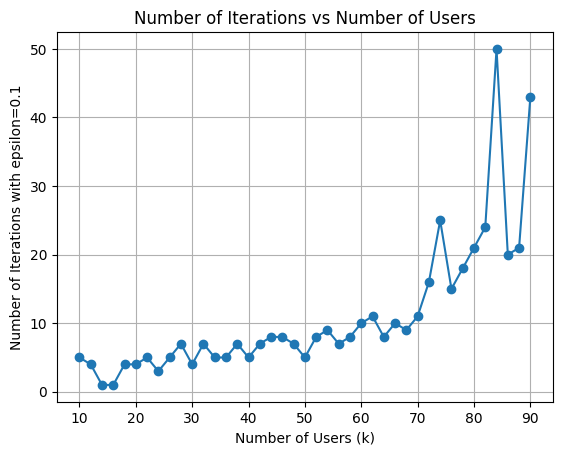

In [96]:
#1.d
K_list = np.array(range(10,Kmax,2), dtype=np.uint32)
epsilon = 0.1
iteration_list = np.zeros(len(K_list))

for idx in range(len(K_list)):
    k = K_list[idx]
    p = np.ones(k)
    new_p = np.ones(k)*0.1
    num_iteration = 0
    _, r, gamma, g = generate_F(k,R,r1,r2,gamma1,gamma2,W,theta)
    while not np.all(np.abs(p - new_p) < epsilon):
        p = new_p
        pg = p*g
        pg1,_ = np.meshgrid(pg,pg)
        pg1[np.eye(len(pg),dtype=bool)] = 0
        sm = np.sum(pg1,axis=1)
        new_p = (r*gamma*(theta*sm + sigma2))/(W*g)
        num_iteration += 1
    iteration_list[idx] = num_iteration
    print(f"k={k}, num_iteration={num_iteration}")

plt.plot(K_list, iteration_list, marker='o')
plt.xlabel('Number of Users (k)')
plt.ylabel(f'Number of Iterations with epsilon={epsilon}')
plt.title('Number of Iterations vs Number of Users')
plt.grid(True)
plt.show()
    

In [97]:
# 1.e

def iterativeE(gamma,beta,tol,seed):
    p=seed.copy()
    p_old = np.inf*np.ones_like(p)
    iter = 0
    while np.sum(abs(p-p_old))>=tol:
        p_old = p.copy()
        sinr = SINR(W,r,p,g,theta,sigma2)
        p = (1-beta)*p + beta*gamma/sinr*p
        iter +=1
    return p, iter

Beta = [0.1,0.3,0.5,0.8,1]
Niter = np.zeros_like(Beta)
_, r, gamma, g = generate_F(Kmax,R,r1,r2,gamma1,gamma2,W,theta)

seed = np.ones(Kmax)
for b in range(len(Beta)):
    p,iter = iterativeE(gamma,Beta[b],1e-3,seed)
    Niter[b] = iter

print(Niter)

[2745. 1115.  724.  484.  399.]


In [98]:
# 1.f

def iterativeF(gamma,alpha,tol,seed,maxIter):
    p = seed.copy()
    p_old = np.inf*np.ones_like(p)
    iter = 0
    while (np.sum(abs(p-p_old))>=tol) & (iter<maxIter):
        p_old = p.copy()
        sinr = SINR(W,r,p,g,theta,sigma2)
        p[sinr<gamma] = alpha*p_old[sinr<gamma]
        p[sinr>gamma] = p_old[sinr>gamma]/alpha
        iter +=1
    return p, iter

Alpha = 10**(np.linspace(0.25,1.5,7)/10)
Niter = np.zeros_like(Alpha)
_, r, gamma, g = generate_F(Kmax,R,r1,r2,gamma1,gamma2,W,theta)

seed = np.ones(Kmax)
for a in range(len(Alpha)):
    p,iter = iterativeF(gamma,Alpha[a],1e-3,seed,5e3)
    Niter[a] = iter

print(Niter)

[5000. 5000. 5000. 5000. 5000. 5000. 5000.]


KeyboardInterrupt: 

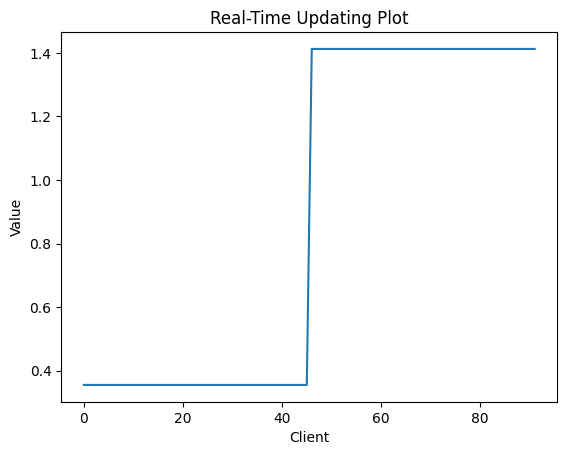

0.05181237304130872
[5. 5. 5. 5. 5. 5. 5.]


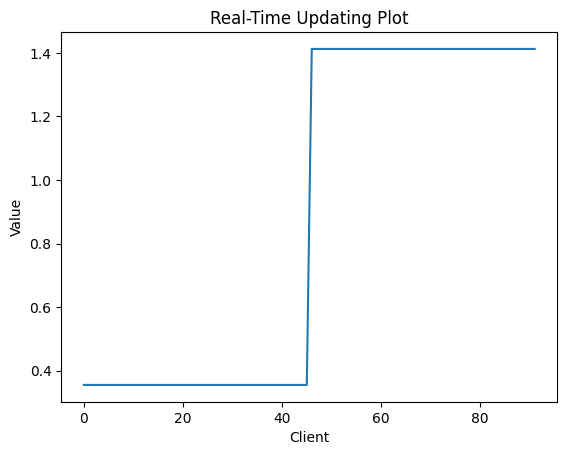

In [99]:
# 1.g

# plt.ion()  # Turn on interactive mode

fig, ax = plt.subplots()
ax.set_title('Real-Time Updating Plot')
ax.set_xlabel('Client')
ax.set_ylabel('Value')

# Initialize an empty list for the data
p_plot = []

# Plot the initial empty data
line, = ax.plot(p_plot)

# Display the plot
display(fig)

def update_plot(p):
    clear_output(wait=True)
    line.set_ydata(p)
    line.set_xdata(range(len(p)))
    ax.relim()
    ax.autoscale_view()
    display(fig)

def iterativeG(gamma,alpha,tol,maxIter):
    p = np.ones(Kmax)
    p_old = np.inf*np.ones_like(p)
    iter = 0
    while (np.sum(abs(p-p_old))/Kmax>=tol) & (iter<maxIter):
        p_old = np.copy(p)
        sinr = SINR(W,r,p,g,theta,sigma2)
        p[sinr > alpha*gamma*p_old] = p_old[sinr > alpha*gamma*p_old]/alpha
        p[sinr < gamma*alpha**(-1)] = p_old[sinr < gamma*alpha**(-1)]*alpha
        iter += 1
        if iter % 1 == 0:
            update_plot(p)
            print(np.sum(abs(p-p_old))/Kmax)
    return p, iter

Alpha = 10**(np.linspace(0.25,1.5,7)/10)
#Alpha = [10**(0.25/10), 10**(0.25/10), 10**(0.25/10)]
Niter = np.zeros_like(Alpha)
_, r, gamma, g = generate_F(Kmax,R,r1,r2,gamma1,gamma2,W,theta)
epsilon = 5e-3

for a in range(len(Alpha)):
    p_alpha,iter = iterativeG(gamma,Alpha[a],epsilon,5e0)
    Niter[a] = iter

print(Niter)

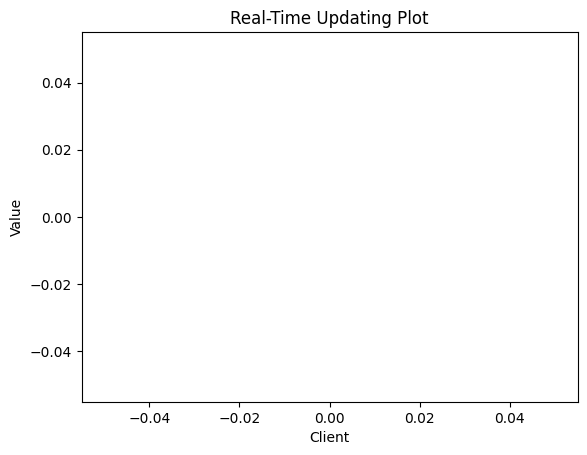

ValueError: operands could not be broadcast together with shapes (20,) (92,) 

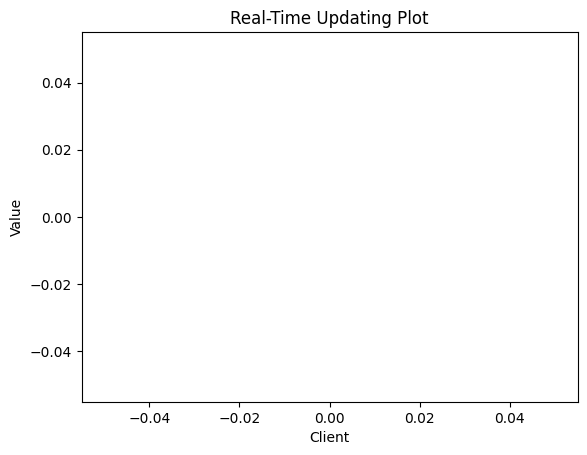

In [103]:
# 2.a


def generate_F2(k,R,r1,r2,gamma1,gamma2,W,theta):
    x,y = sample_users(k,R)
    r = np.concatenate((r1*np.ones(k//2),r2*np.ones(k//2)))
    gamma = np.concatenate((gamma1*np.ones(k//2),gamma2*np.ones(k//2)))
    d = np.sqrt(x**2+y**2)
    L = -128.1 - 37.6*np.log10(d)
    l = 10**(L/10)
    return r, gamma, l

def iterativeE(gamma,beta,tol,seed,k,l,lim_iteration):
    p=seed
    p_old = np.inf*np.ones_like(p)
    iter = 0
    lamda = 0.5
    while np.sum(abs(p-p_old))>=tol and lim_iteration > iter:

        h = np.random.exponential(1/lamda,k)
        g = l*h

        p_old = p.copy()
        sinr = SINR(W,r,p,g,theta,sigma2)
        p = ((1-beta)*p + p*beta*gamma/sinr)
        iter +=1
        if iter % 10 == 0:
            update_plot(p)
        
    return p, iter

fig, ax = plt.subplots()
ax.set_title('Real-Time Updating Plot')
ax.set_xlabel('Client')
ax.set_ylabel('Value')
p_plot = []
line, = ax.plot(p_plot)
display(fig)

lim_iteration = 1000
Beta = [0.1,0.3,0.5,0.8,1]
Niter = np.zeros_like(Beta)
r, gamma,l = generate_F2(Kmax,R,r1,r2,gamma1,gamma2,W,theta)

seed = np.ones(Kmax)
for b in range(len(Beta)):
    p,iter = iterativeE(gamma,Beta[b],1e-3,seed,Kmax,l,lim_iteration)
    Niter[b] = iter

print(Niter)

# Exercice 3

In [59]:
# 1)

r = 1
W = 3.84*10**6
theta = 0.4
sigma2 = 10**(-104/10)*1e-3
P = 10**(40/10)*1e-3

def measure_achievement_ratio(K,R,gamma,n_avg=1):
    x,y = sample_users(K,r)
    d = np.sqrt(x**2+y**2)
    L = -128.1 - 37.6*np.log10(d)
    l = 10**(L/10)
    history = np.zeros((n_avg,1))
    for i in range(n_avg):
        h = np.random.exponential(0.5,K)
        g = l*h
        p = P/K
        SINR = W/R*p*g/(theta*(K-1)*p*g+sigma2)
        history[i] = np.mean(SINR>=gamma)

    return history

K_values = np.array(range(1,100))
deltas = np.zeros(len(K_values))

for i,K in enumerate(K_values) :
    ach_rat = measure_achievement_ratio(K,240*1e3,10**(10/10),100)
    deltas[i] = np.mean(ach_rat)

print(deltas)
print(f'The maximum number of users on the network is {K_values[np.sum(deltas>=0.9)]}')

[0.99  0.965 0.92  0.845 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.   ]
The maximum number of users on the network is 4


In [60]:
# 2)

T = 1000
I = 50
gamma_i = 10**(10/10)
R_i = 240e3
L = 16                  # = W/R_i
P = 10**(40/10)*1e-3
K_list = [10, 20, 30]
radius = 1
lamda = 0.5
sigma2 = 10**(-104/10)*1e-3

for K in K_list:
    try_averages = np.zeros(I)
    for idx in range(I):
        # Generate K users
        x, y = sample_users(K, radius)
        # Compute distance and pathloss effect
        d = np.sqrt(x**2+y**2)
        L = -128.1 - 37.6*np.log10(d)
        l = 10**(L/10)
        Average_rates = np.zeros(K)

        for t in range(T):
            h = np.random.exponential(1/lamda,K)
            g = l*h
            SNR_base = P*g/sigma2
            SNR = SNR_base.copy()
            C = np.ones(K)
            current_rates = np.zeros(K)
            proportional_fairness = np.zeros(K)

            for i in range(K):
                while SNR[i] > gamma_i and C[i] < 15:
                    SNR[i] = SNR_base[i]/C[i]
                    C[i] += 1
                # print(f"SNR[i] = {SNR[i]} and gamm_i = {gamma_i}")

                current_rates[i] = C[i] * R_i
                if Average_rates[i] != 0:
                    proportional_fairness[i] = np.argmax(current_rates[i]/Average_rates[i])
                else:
                    proportional_fairness[i] = np.inf
            selected_user = np.argmax(proportional_fairness)
            Average_rates[selected_user] += -(1/(t+1))*Average_rates[selected_user] + current_rates[selected_user]/(t+1)
            Average_rates[range(K) != selected_user] -= Average_rates[range(K) != selected_user]/(t+1)
        try_averages[idx] = np.mean(Average_rates)
    print(f"K={K}, Average Rate={np.mean(try_averages):.2f}, Standard Deviation={np.std(try_averages):.2f}")

K=10, Average Rate=299041.44, Standard Deviation=49399.28
K=20, Average Rate=143146.08, Standard Deviation=29004.78
K=30, Average Rate=96209.44, Standard Deviation=18075.67
